# Stereo Panning Spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import pandas as pd
plt.style.use('dark_background')

#1. Load and plot each channel of the stereo file
    #Load
filename = 'Runawaytest.wav'#'SinguhrI/Audio/001 Erwin Stache - Klangkasten.wav' #'Runawaytest.wav'
y, sr = librosa.load(filename, mono=False)
t = np.arange(y.shape[1]) / sr

#plot
plt.figure(figsize=(10,6))

# plot left channel
plt.subplot(3, 1, 1)
plt.plot(t, y[0], color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.9, 0.9])
 
#plot right channel
plt.subplot(3, 1, 2)
plt.plot(t, y[1], color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.9, 0.9])

#plot stereo
plt.subplot(3, 1, 3)
librosa.display.waveplot(y, sr=sr, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.9, 0.9])

plt.tight_layout()



"If we denote STFT of the left, right signals $X1(t)$, $Xr(t)$ for a particular analysis window $Xl(k)$, $Xr(k)$, where $k$  the frequency index, we can define the following similarity measure:

$$ V = 2 * \frac{|Xl(k)Xr^*(k)|} {|Xl(k)|^2 + |Xr(k)|^2}$$

Where $*$ denotes complex conjugation." 

(-0.51, 0.51)

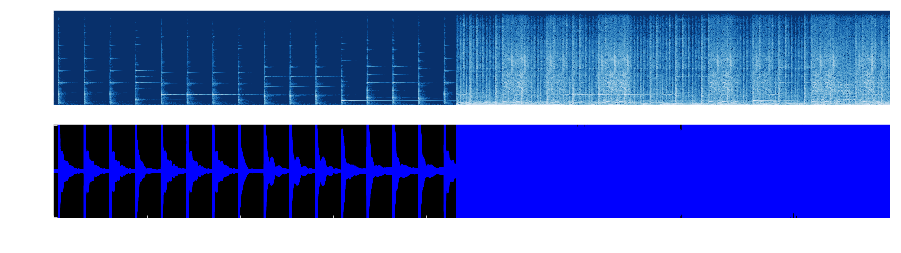

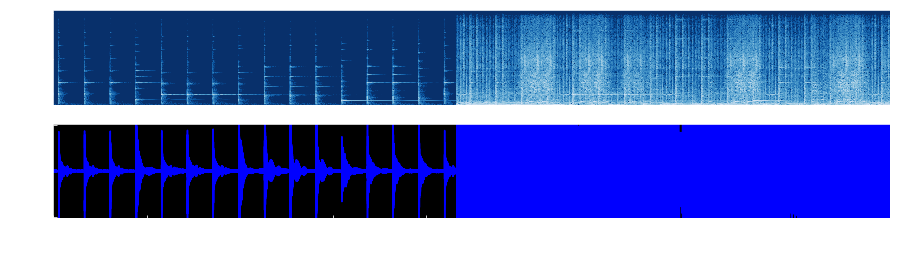

In [2]:

#as fortranarray
y_left=np.asfortranarray(y[0])
y_right=np.asfortranarray(y[1])

#apply stft to each channel

stft_left = np.abs(librosa.stft(y_left)) 
stft_right = np.abs(librosa.stft(y_right)) 

#Plot stft

# plot left channel
S_left = librosa.amplitude_to_db(abs(stft_left))## To log scale
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(4, 1, 1)
librosa.display.specshow(S_left, sr=sr, x_axis='time', y_axis='frames', cmap='Blues_r')
#plt.colorbar(format='%+2.0f dB')

plt.subplot(4, 1, 2, sharex=ax1)
plt.plot(t, y[0], color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.51, 0.51])


# plot right channel
S_right = librosa.amplitude_to_db(abs(stft_right))## To log scale
plt.figure(figsize=(15, 8))
ax2 = plt.subplot(4, 1, 3)
librosa.display.specshow(S_right, sr=sr, x_axis='time', y_axis='frames', cmap='Blues_r')
#plt.colorbar(format='%+2.0f dB')

plt.subplot(4, 1, 4, sharex=ax2)
plt.plot(t, y[1], color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.51, 0.51])



0.99957156
-0.9998549


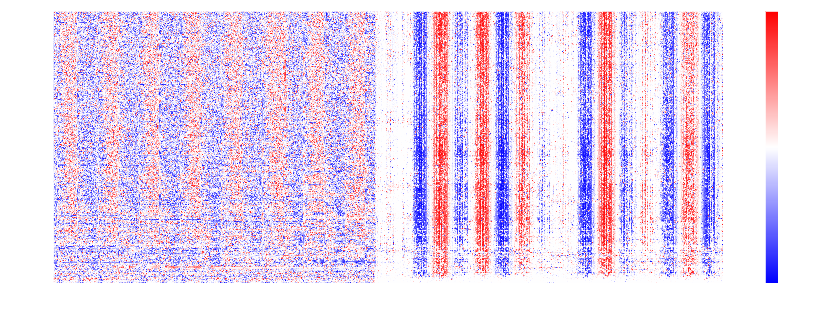

In [3]:
##### Define functions and equations

def similarity(stft_left, stft_right): ## Equation [1]
    num = np.multiply(stft_left,stft_right) 
    den = np.add(np.square(stft_left), np.square(stft_right))    
    sim = np.divide(num, den) 
    return np.multiply(2,sim)

def similarity_left(stft_left, stft_right):  #Equation [3]
    num = np.multiply(stft_left,stft_right)
    den = np.square(stft_left)
    sim_left = np.divide(num, den) 
    return sim_left
  
def similarity_right(stft_left, stft_right): #Equation [3]
    num = np.multiply(stft_left, stft_right)
    den = np.square(stft_right)
    sim_right = np.divide(num, den) 
    return sim_right

Vl = similarity_left(stft_left, stft_right) #Equation [3]
Vr = similarity_right(stft_left, stft_right) #Equation [3]
V = similarity(stft_left, stft_right) ## Equation [1]

delta = np.subtract(Vl, Vr)  #Equation [4]
delta_sign = np.sign(delta) #Equation[5]
sps = np.multiply(np.subtract(1, V), delta_sign) #Equation[6]


print(np.amax(sps))
print(np.amin(sps))

plt.figure(figsize=(15, 5))
librosa.display.specshow(sps, x_axis='time', y_axis="frames", cmap="bwr", vmin=-1.0, vmax= 1.0)
plt.colorbar()




In [4]:
rms = librosa.feature.rmse(S=sps) #Equation[7]

#get frequency bands
sps_high=sps[58:512] #250 to 22.050
sps_mid=sps[6:58] #250 to 2500
sps_low=sps[0:6] #0 to 250Hz

rms_low = librosa.feature.rmse(S=sps_low)
rms_mid = librosa.feature.rmse(S=sps_mid)
rms_high = librosa.feature.rmse(S=sps_high)

#join all to create 4d vector
phi = np.array([rms, rms_low, rms_mid, rms_high]) #Equation[8]
phi = np.reshape(phi, (phi.shape[0],phi.shape[2]) )

#pandas to calculate mean and std
phi = pd.DataFrame(data=phi)

#mean and std
P = phi.T.rolling(40, min_periods=1).agg({np.std, np.mean})

#Final 16D vector
Grand_mean = P.mean()#df['grand']
Grand_std = P.std()#df['grand']
SPSF = np.concatenate((Grand_mean.to_numpy(), Grand_std.to_numpy())) #Final 16d Vector
print(SPSF)



[0.08368929 0.30598847 0.10420449 0.12832024 0.06575129 0.22052721
 0.09199577 0.31719149 0.07838538 0.09540194 0.02238208 0.06671887
 0.0349003  0.08200836 0.08032907 0.09810955]
